# 트위터 감정 분석

이번 실습에서는 트위터 메시지(트윗)의 감정을 분석하는 RNN Classifier를 만들겠습니다.

감정에는 긍정, 부정, 중립의 세 가지 레이블이 있습니다.

이 정의에 따라 트윗에 담긴 감정을 태깅하였고 이 데이터를 통해 주어진 트윗에 감정을 분석하는 classifier를 만드는 것이 이번 실습에서의 목표입니다.

## 데이터 파일 다운로드

데이터 파일을 다운로드 하기 위해 특수 명령어인 gdown을 사용하였습니다.

(ipython 형태로 배포될 경우 data 폴더를 만들어 넣겠습니다.)

데이터 출처: https://www.kaggle.com/vivekrathi055/sentiment-analysis-on-financial-tweets

In [2]:
!gdown --id 1CElFsrPshUPyLIDk0MpkJR01cIcqNdra

!gdown --id 1tll145FRmWH8pfnlOCV_mYb3MTLvxf4K

!gdown --id 1WJOfcaaW_5nc0Dr573FhX5zFyC5NCp9Z

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CElFsrPshUPyLIDk0MpkJR01cIcqNdra
To: /content/vocab.csv
100% 32.3k/32.3k [00:00<00:00, 45.0MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tll145FRmWH8pfnlOCV_mYb3MTLvxf4K
To: /content/valid.csv
100% 31.5k/31.5k [00:00<00:00, 46.4MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https:/

`train.csv` 파일을 열어보면 한 라인에 두 개의 열이 있습니다. 

첫 번째 열에는 트위터 메시지인 트윗이 있고 오른쪽에는 태깅된 감정이 있습니다.

- 0: 부정
- 1: 중립
- 2: 긍정

이렇게 세 가지의 감정이 태깅된 것을 알 수 있습니다.

In [3]:
with open("train.csv") as csv_f:
    head = "\n".join([next(csv_f) for x in range(5)])
print(head)

critic survey ashford hospit prime ahp amp kimco realti kim,0

analyst adopt bullish outlook robert half intern inc rhi,1

zack rank strong buy semiconductor stock mlnx intc mchp,2

setup like watch wed roku iq sfix shop spot ual goo twlo nflx xrt tsla sq bidu pypl labu biib kss kre,2

invesco ivz price target lower credit suiss group,1



## 라이브러리 로드

코드 실행에 필요한 라이브러리를 로드합니다.

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import Image

## train 함수
train 함수는 train 데이터를 통해 모델을 학습하고 valid 데이터로 이를 검증하는 함수입니다.

- 문제 1. train 함수 내 model 구성에 있어 마지막에 classification을 위해 dense layer를 추가해주세요. 힌트) class의 개수는 3개입니다.

In [5]:
def train(train_dataset, valid_dataset, epochs=20):
    # vocab.csv에 적혀진 단어를 기반으로 단어를 벡터로 바꾸는 encoder를 만듭니다.
    encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(output_sequence_length=200,
                                                                           vocabulary="./vocab.csv")

    # RNN classifier 모델을 만듭니다.
    # 단어 => encoder => Embedding => 양방향 RNN => Dense => Dense의 구조입니다.
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()), output_dim=300, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(300)),
        tf.keras.layers.Dense(300, activation='relu'),
        # <ToDo>: model의 마지막에 classification을 위해 dense layer를 추가해주세요.
        tf.keras.layers.Dense(3)
    ])

    # 모델의 loss 함수와 optimizier를 정합니다.
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

    # train 데이터로 학습시키며 valid 데이터로 성능을 확인합니다.
    history = model.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, validation_steps=1,
                        use_multiprocessing=True, workers=32)

    return model, history

## test 함수

학습된 모델로 테스트 데이터를 이용하여 모델의 성능을 평가합니다.

In [6]:
def test(model, test_dataset):
    # test 데이터를 이용하여 모델을 검증합니다.
    test_loss, test_acc = model.evaluate(test_dataset)
    
    # 결과를 출력합니다.
    print('Test Loss: {}'.format(test_loss))
    print('Test Accuracy: {}'.format(test_acc))

## 그래프 그리는 함수

epoch에 따른 train loss와 validation loss 그래프를 그립니다.

In [7]:
def draw_graph(history, metric='loss'):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.savefig('train_valid_loss.png', bbox_inches='tight')

    Image('train_valid_loss.png')

## 데이터 불러오기

- 문제 2. `valid_dataset`을 불러오세요. 힌트) `train_dataset`을 참고하세요.

In [8]:
# 데이터의 기본 형태에 대한 정보입니다.
column_names = ["text", "label"]
column_defaults = ["string", "int32"]
root_path = "./"
train_file_path = root_path + "train.csv"
valid_file_path = root_path + "valid.csv"

# train 데이터 csv 파일을 읽어옵니다.
train_dataset = tf.data.experimental.make_csv_dataset(train_file_path, column_names=column_names, batch_size=320,
                                                      label_name="label", column_defaults=column_defaults,
                                                      header=False, num_epochs=1)

# <ToDo>: valid_dataset을 불러오세요.
valid_dataset = tf.data.experimental.make_csv_dataset(valid_file_path, column_names=column_names, batch_size=320,
                                                      label_name="label", column_defaults=column_defaults,
                                                      header=False, num_epochs=1)

# <ToDo>: valid_dataset과 test_dataset을 불러오세요.
train_dataset = train_dataset.map(lambda text, label: (text["text"], label))
valid_dataset = valid_dataset.map(lambda text, label: (text["text"], label))

## 모델 학습

- 문제 3. `train` 함수를 이용하여 train data를 통해 모델 학습을 진행하세요.

In [9]:
# <ToDo>: 학습을 위해 train 함수의 적절한 parameter를 전달해주세요.
model, history = train(train_dataset, valid_dataset, epochs=20)  # Problem 3

Epoch 1/20
7/7 [==============================] - 16s 447ms/step - loss: 1.0944 - accuracy: 0.5065 - val_loss: 1.0852 - val_accuracy: 0.6313
Epoch 2/20
7/7 [==============================] - 0s 53ms/step - loss: 1.0813 - accuracy: 0.5840 - val_loss: 1.0712 - val_accuracy: 0.6094
Epoch 3/20
7/7 [==============================] - 0s 41ms/step - loss: 1.0650 - accuracy: 0.5805 - val_loss: 1.0469 - val_accuracy: 0.6438
Epoch 4/20
7/7 [==============================] - 0s 40ms/step - loss: 1.0400 - accuracy: 0.5795 - val_loss: 1.0132 - val_accuracy: 0.6281
Epoch 5/20
7/7 [==============================] - 0s 41ms/step - loss: 1.0003 - accuracy: 0.5795 - val_loss: 0.9620 - val_accuracy: 0.6250
Epoch 6/20
7/7 [==============================] - 0s 40ms/step - loss: 0.9440 - accuracy: 0.5795 - val_loss: 0.9183 - val_accuracy: 0.6031
Epoch 7/20
7/7 [==============================] - 0s 42ms/step - loss: 0.8960 - accuracy: 0.5795 - val_loss: 0.8635 - val_accuracy: 0.6281
Epoch 8/20
7/7 [=========

## 그래프 출력

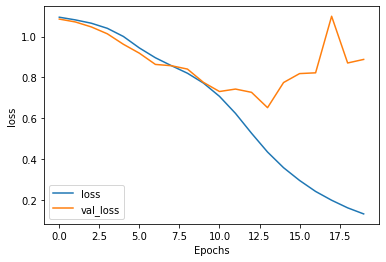

In [10]:
# 학습 히스토리를 통해 training loss와 validation loss를 그래프로 그립니다.
draw_graph(history)

## 추가 질문

위의 그림을 보면서 최적의 Epoch 개수를 찾아보세요.

Valid Loss가 가장 적은 부분을 찾아보았을 때,
Epoch 14가 가장 최적의 Epoch 개수이다.